In [9]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn as nn

torch.Size([64, 3, 64, 64])
28820


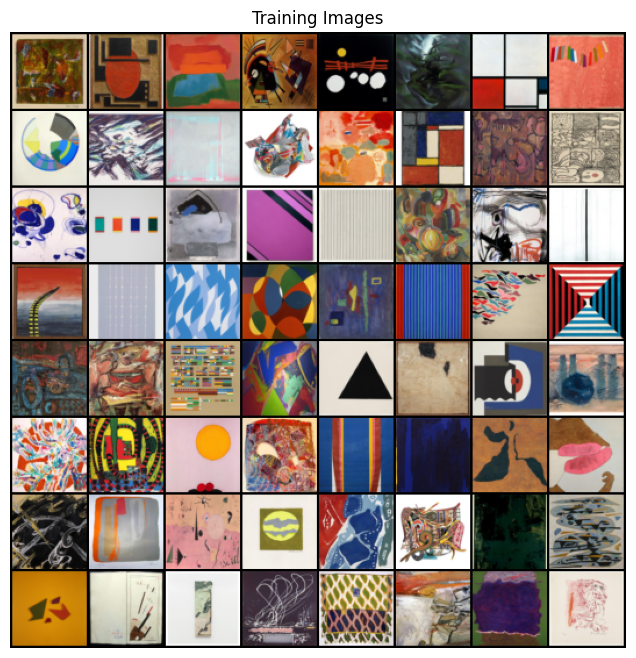

In [150]:
img_size = 64
batch_size = 64
dataset = 'data/art/'

transform = transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

dataset = dset.ImageFolder(root=dataset,
                           transform=transform)
dataloader = th.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

device = th.device("cuda:0" if (th.cuda.is_available()) else "cpu")
real_batch = next(iter(dataloader))
print(real_batch[0].shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
print(len(dataset))

In [156]:
in_channels = 3
d_out = 64
z_size = 256
def conv_block_gen(in_channels, out_channels, kernel_size, stride, padding, batchnorm=True):
    seq = []
    seq.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))
    if batchnorm:
        seq.append(nn.BatchNorm2d(out_channels))
    seq.append(nn.ReLU(True))
    return nn.Sequential(*seq)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_block_gen(z_size, d_out*8, 4, 1, 0)
        self.conv2 = conv_block_gen(d_out*8, d_out*4, 4, 2, 1)
        self.conv3 = conv_block_gen(d_out*4, d_out*2, 4, 2, 1)
        self.conv4 = conv_block_gen(d_out*2, d_out, 4, 2, 1)
        self.out = nn.Sequential(
            nn.ConvTranspose2d(d_out, in_channels, 4, 2, 1),
            nn.Tanh()
        )
    
    def forward(self, input):
        out1 = self.conv1(input)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        out4 = self.conv4(out3)
        out = self.out(out4)
        return out
        

In [157]:
def conv_block_disc(in_channels, out_channels, kernel_size, stride, padding, batchnorm=True):
    seq = []
    seq.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))
    if batchnorm:
        seq.append(nn.BatchNorm2d(out_channels))
    seq.append(nn.LeakyReLU(0.2, True))
    return nn.Sequential(*seq)



class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_block_disc(in_channels, d_out, 4, 2, 1, batchnorm=False)
        self.conv2 = conv_block_disc(d_out, d_out*2, 4, 2, 1)
        self.conv3 = conv_block_disc(d_out*2, d_out*4, 4, 2, 1)
        self.conv4 = conv_block_disc(d_out*4, d_out*8, 4, 2, 1)
        self.out = nn.Sequential(
            nn.Conv2d(d_out*8, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, input):
        out1 = self.conv1(input)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        out4 = self.conv4(out3)
        out = self.out(out4)
        return out

In [158]:
gen = Generator()
gen.cuda()
disc = Discriminator()
disc.cuda()

def init_weights(net):
    if isinstance(net, nn.ConvTranspose2d) or isinstance(net, nn.Conv2d):
        net.weight.data.normal_(mean=0.0, std=0.02)

init_weights(gen)
init_weights(disc)



In [159]:
import torch.optim as optim
lr = 0.0002
loss = nn.BCELoss()
eval_noise = th.randn(64, z_size, 1, 1, device=device)
disc_opt = optim.Adam(disc.parameters(), lr=0.00015, betas=(0.5, 0.999))
gen_opt = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))

In [160]:


epochs = 5
gen_losses = []
disc_losses = []
eval = []
print("Data size:", len(dataloader))
for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
        # real image loss
        disc.zero_grad()
        real_images = data[0].to(device)
        curr_batch_size = real_images.shape[0]
        labels_real = th.ones((curr_batch_size,), device=device) - 0.1
        disc_out1 = disc(real_images).squeeze()
        real_loss = loss(disc_out1, labels_real)
        real_loss.backward()

        # fake image loss
        noise = th.randn(curr_batch_size, z_size, 1, 1, device=device)
        fake_images = gen(noise)
        labels_fake = th.zeros((curr_batch_size,), device=device) + 0.1
        disc_out2 = disc(fake_images.detach()).squeeze()
        fake_loss = loss(disc_out2, labels_fake)
        fake_loss.backward()

        # total error
        disc_loss = (real_loss + fake_loss) / 2
        disc_opt.step()
        disc_losses.append(disc_loss.item())

        # gen loss (2 steps)
        gen.zero_grad()
        labels_gen = th.ones((curr_batch_size,), device=device) - 0.1
        disc_out_gen = disc(fake_images).squeeze()
        gen_loss = loss(disc_out_gen, labels_gen)
        gen_loss.backward()
        gen_opt.step()
        gen_losses.append(gen_loss.item())

        noise = th.randn(curr_batch_size, z_size, 1, 1, device=device)
        fake_images = gen(noise)
        gen.zero_grad()
        labels_gen = th.ones((curr_batch_size,), device=device) - 0.1
        disc_out_gen = disc(fake_images).squeeze()
        gen_loss = loss(disc_out_gen, labels_gen)
        gen_loss.backward()
        gen_opt.step()
        gen_losses.append(gen_loss.item())

        if i % 50 == 0:
            print("Epoch%:", epoch/epochs, "batch%:", i/len(dataloader), "disc_loss:", disc_loss.item(), "gen_loss:", gen_loss.item())
            with th.no_grad():
                eval.append(gen(eval_noise))



Data size: 451
Epoch%: 0.0 batch%: 0.0 disc_loss: 0.7457873821258545 gen_loss: 0.9088331460952759
Epoch%: 0.0 batch%: 0.11086474501108648 disc_loss: 0.642193078994751 gen_loss: 3.2499566078186035
Epoch%: 0.0 batch%: 0.22172949002217296 disc_loss: 0.3764120042324066 gen_loss: 2.096806287765503
Epoch%: 0.0 batch%: 0.3325942350332594 disc_loss: 0.5772663950920105 gen_loss: 1.1057049036026


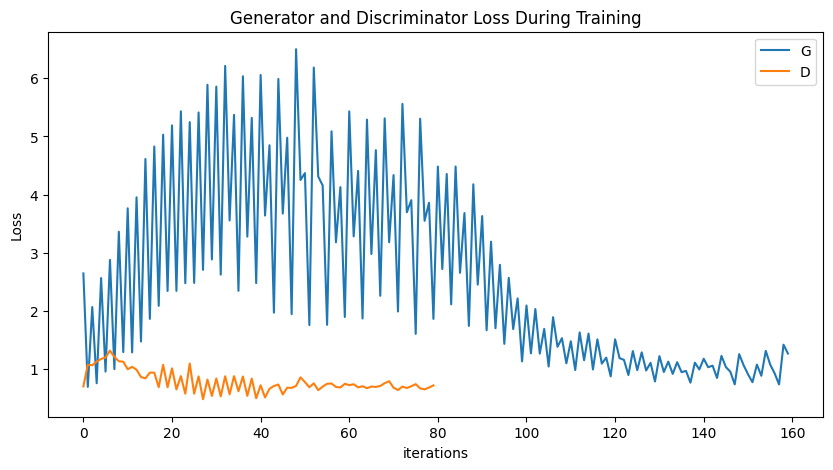

In [148]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses,label="G")
plt.plot(disc_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


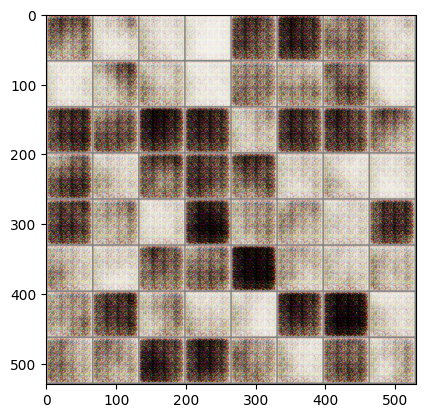

In [149]:
import matplotlib.cm as cm
import matplotlib.animation as animation
import torchvision

frames = []
fig = plt.figure()
for img in eval:
    grid_img = torchvision.utils.make_grid(img.cpu(), nrow=8)
    im = plt.imshow((grid_img.permute(1, 2, 0).numpy() / 2 + 0.5), animated=True)
    frames.append([im])
ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True,
                                repeat_delay=1000)
ani.save('comics.gif')


In [ ]:
# datasets sourced from the following links. Download and format in data/[data_name]/[class]/...png:
# https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
# https://www.kaggle.com/datasets/defileroff/comic-faces-paired-synthetic-v2
# https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models
# https://www.kaggle.com/datasets/goprogram/abstract-art